In [72]:
import torch
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

In [73]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3050 Laptop GPU


In [74]:
n_samples = 1000

X,y = make_circles(n_samples=n_samples, noise=0.03, factor=0.8, random_state=42)

In [75]:
# make dataframe of the circle data
df = pd.DataFrame({
    "x1": X[:,0],
    "x2": X[:,1],
    "y": y 
})

df.head()

,x1,x2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [76]:
df['y'].value_counts()

y
1    500
0    500
Name: count, dtype: int64

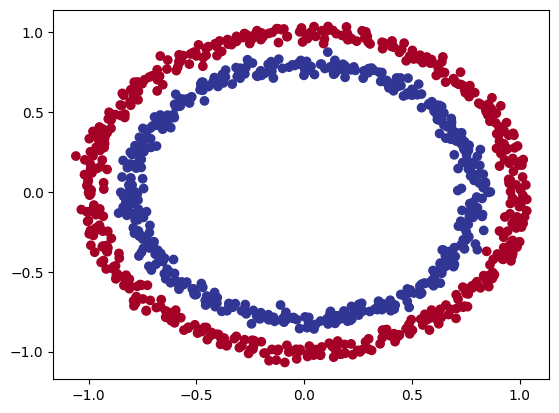

In [77]:
# lets visualize the data
plt.scatter(x=df.x1,y=df.x2, c=df.y, cmap=plt.cm.RdYlBu)

In [78]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [79]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [81]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1)
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [82]:
# in a similar way we can use Sequential
torch.manual_seed(42)
model_1 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('1.bias', tensor([-0.2060], device='cuda:0'))])

In [83]:

with torch.inference_mode():
    predict = model_1(X_test)
    x_t = X_test.cpu().numpy()
    y_t = y_test.cpu().numpy()
    pred = predict.cpu().numpy()
    print(pred)

# plt.scatter(x_t[:,0], x_t[:,1], c=y_t, marker='o', label='Ground Truth', alpha=0.5, cmap='viridis')
# plt.scatter(x_t[:,0], x_t[:,1], c=pred, marker='x', label='Predictions', alpha=0.8, cmap='plasma')
# plt.legend()
# plt.show()


[[-0.12691721]
 [-0.09673034]
 [-0.19083585]
 [-0.10886917]
 [-0.1666869 ]
 [-0.14844623]
 [-0.08258729]
 [-0.0946364 ]
 [-0.19175822]
 [-0.09443946]
 [-0.1255632 ]
 [-0.11825969]
 [-0.0870945 ]
 [-0.19902673]
 [-0.19603203]
 [-0.11765441]
 [-0.0954328 ]
 [-0.13810998]
 [-0.14268947]
 [-0.15680304]
 [-0.0954859 ]
 [-0.1150925 ]
 [-0.15187195]
 [-0.14965382]
 [-0.08178321]
 [-0.09040019]
 [-0.20420453]
 [-0.13651913]
 [-0.1991115 ]
 [-0.19481526]
 [-0.0959798 ]
 [-0.08082771]
 [-0.11948615]
 [-0.18345225]
 [-0.12354938]
 [-0.10117751]
 [-0.11494291]
 [-0.19769335]
 [-0.19085944]
 [-0.19797933]
 [-0.15527493]
 [-0.1856674 ]
 [-0.09662215]
 [-0.17332524]
 [-0.11666907]
 [-0.09811966]
 [-0.16126117]
 [-0.0945135 ]
 [-0.10671799]
 [-0.15586168]
 [-0.11126371]
 [-0.11437241]
 [-0.12826961]
 [-0.18141583]
 [-0.10111457]
 [-0.20450479]
 [-0.10411738]
 [-0.19991493]
 [-0.17128024]
 [-0.17971632]
 [-0.15664124]
 [-0.09219532]
 [-0.17702697]
 [-0.19895771]
 [-0.12224609]
 [-0.10615519]
 [-0.11849

For nn.BCELoss(): we need to pass the output to sigmoid function before calculating the loss.


### Binary Cross Entropy (Log Loss):

Loss Function = -y*log(p(y)) - (1-y)*log(1-p(y))

- Logits Layer typically produces value from -inf to inf, log(p/(1-p)) zero at 0.5 
- Info on binary cross entropy, which is the loss function used for Binary Classification.
- If we fit a model to perform this classification, it will predict a probability of being green (1/yes) to each one of our points. Given what we know about the color (or 1/yes,0/no) of the points, how can we evaluate how good (or bad) are the predicted probabilities? This is the whole purpose of the loss function! It should return high values for bad predictions and low values for good predictions.
    - Lets say when my actual value is 1 and the predicted probablity is 0.9 then in the loss will be very less as in log graph between 0 to 1, at 0 log tends to - infinity and at 1 it is zero.
    - on the other hand if the predicted probability is 0.3, then loss will be -log(0.3) which will be higher value than that of when the prediction was right in the above point
    - similarly if the actual output is 0 and the prediction probability is 0.2 then loss will be -log(0.8) which is less addition to the loss as we have correctly predicted.
- Why are we taking log ?
    - We need to return high values for bad predictions.
    - As our output from model is probabilty ranging from 0 to 1, log tends to -infinity at 0 and log is 0 at 1, so huge loss can be added if the prediction is too wrong.

- Log of values between 0 and 1 is negative we take negative of logs. 
- Entropy is the measure of uncertainity, associated with the given distribution.

In [84]:
# observation: if we dont have an activation function and just have hidden layers output, 
# in case of binary classification it is similar to random guessing (50-50)
# for classification we need binary cross entropy or categorical cross entrophy

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),lr=0.01)


In [85]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    accuracy = (correct/len(y_pred))*100
    return accuracy

### Model Training

In [86]:
# this outputs raw logits (output ranging from -inf to +inf)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [87]:
# So here we added an activation function, which converts them into probabilities.
torch.cuda.manual_seed(42)

epochs = 300
acc = []
test_loss = []
train_loss = []
epochs_count = [i for i in range(1,epochs+1)]

for epoch in range(epochs):
    model_1.train()

    # Forward pass through the model
    y_logits_train = model_1(X_train).squeeze()
    y_pred_train = torch.round(torch.sigmoid(y_logits_train))

    # cal loss
    loss_train = loss_fn(y_logits_train,y_train) # as we are using BCEWithLogitsLoss
    train_loss.append(loss_train)

    acc.append(accuracy_fn(y_train,y_pred_train))

    optimizer.zero_grad()

    loss_train.backward()

    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():

        y_logits_test = model_1(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(y_logits_test))

        loss_test = loss_fn(y_logits_test,y_test)
        test_loss.append(loss_test)
    

In [88]:
test_loss = [ele.cpu().item() for ele in test_loss]
train_loss = [ele.cpu().item() for ele in train_loss]

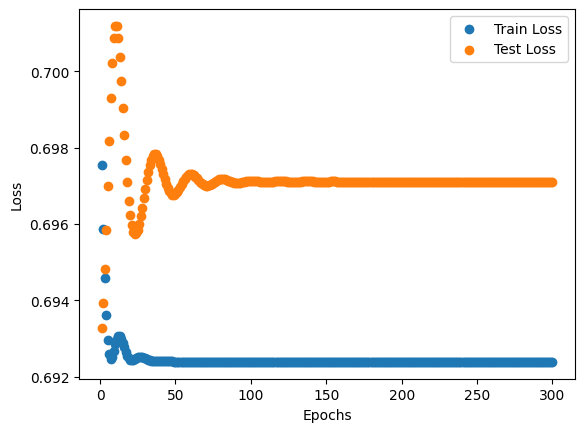

In [89]:
plt.scatter(epochs_count,train_loss,label='Train Loss')
plt.scatter(epochs_count,test_loss,label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

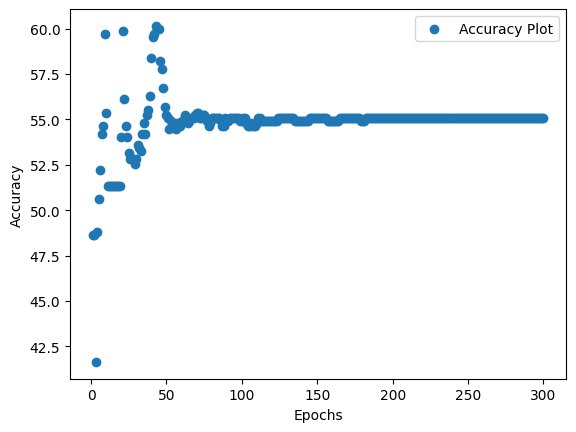

In [90]:
plt.scatter(epochs_count,acc,label="Accuracy Plot")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

Note: Our model hasnt learned anything.

In other words we can just visualize the predictions, so we will use 'plot_decision_boundary

In [91]:

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor,y: torch.Tensor):
    
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [92]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots linear training data and test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

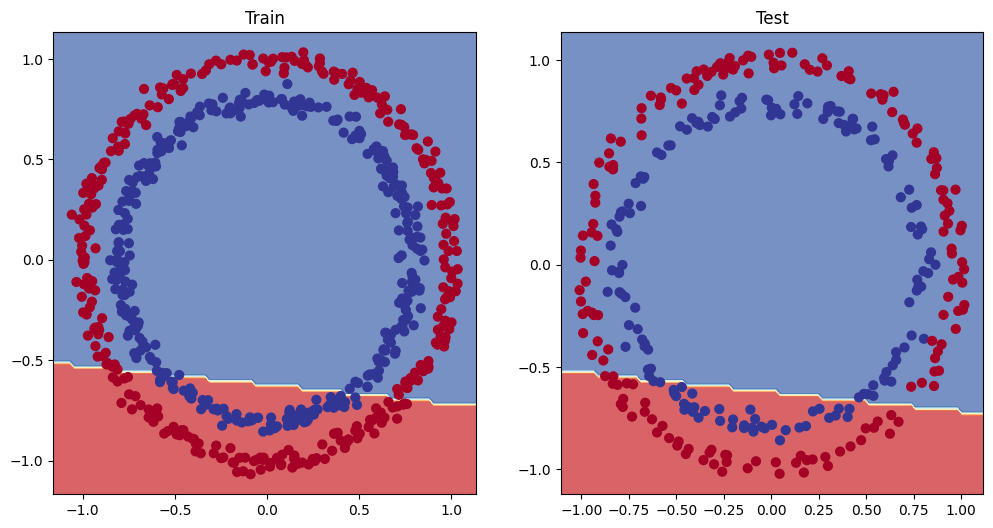

In [93]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

#### So whats happening ?
We are drawing a straight line to segregate the points, between different classes. Which means linear layer wont work here

#### How to improve (model perspective)?
- Add more layers -> giving the model more chances to learn about the patterns
- Add more hidden units -> go from 5 to [10,20,30...] units.
- Fit for longer, increase the epochs.
- Change the activation function.
- Try to play with learning rate.



In [141]:
torch.cuda.manual_seed(40)
model_2 = nn.Sequential(
    nn.Linear(in_features=2,out_features=8),
    # nn.LeakyReLU(0.1),
    nn.ELU(0.1),
    nn.Linear(in_features=8,out_features=4),
    # nn.LeakyReLU(0.1),
    nn.ELU(0.1),
    nn.Linear(in_features=4,out_features=1)
)

model_2.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ELU(alpha=0.1)
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ELU(alpha=0.1)
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [142]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),lr=0.01)

In [143]:
# So here we added an activation function, which converts them into probabilities.
torch.cuda.manual_seed(42)

epochs = 300
acc = []
test_loss = []
train_loss = []
epochs_count = [i for i in range(1,epochs+1)]

for epoch in range(epochs):
    model_2.train()

    # Forward pass through the model
    y_logits_train = model_2(X_train).squeeze()   # (nx1 data was output)
    y_pred_train = torch.round(torch.sigmoid(y_logits_train))

    # cal loss
    loss_train = loss_fn(y_logits_train,y_train) # as we are using BCEWithLogitsLoss
    train_loss.append(loss_train)

    acc.append(accuracy_fn(y_train,y_pred_train))

    optimizer.zero_grad()

    loss_train.backward()

    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():

        y_logits_test = model_2(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(y_logits_test))

        loss_test = loss_fn(y_logits_test,y_test)
        test_loss.append(loss_test)
    

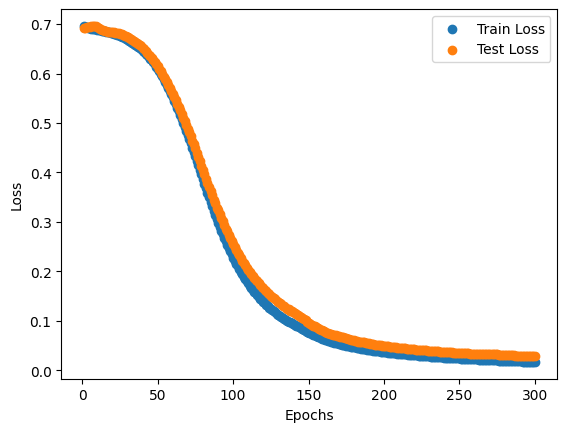

In [144]:
test_loss = [ele.cpu().item() for ele in test_loss]
train_loss = [ele.cpu().item() for ele in train_loss]

plt.scatter(epochs_count,train_loss,label='Train Loss')
plt.scatter(epochs_count,test_loss,label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


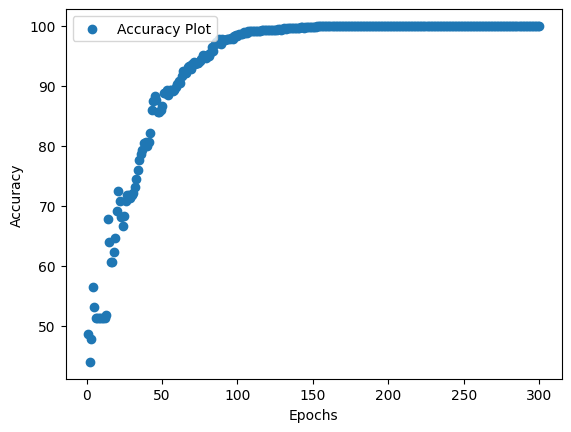

In [145]:
plt.scatter(epochs_count,acc,label="Accuracy Plot")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

As we introduced LeakyReLU activation function it improved our model by introducing nonlinearity, which is essential for learning complex patterns like concentric circles.

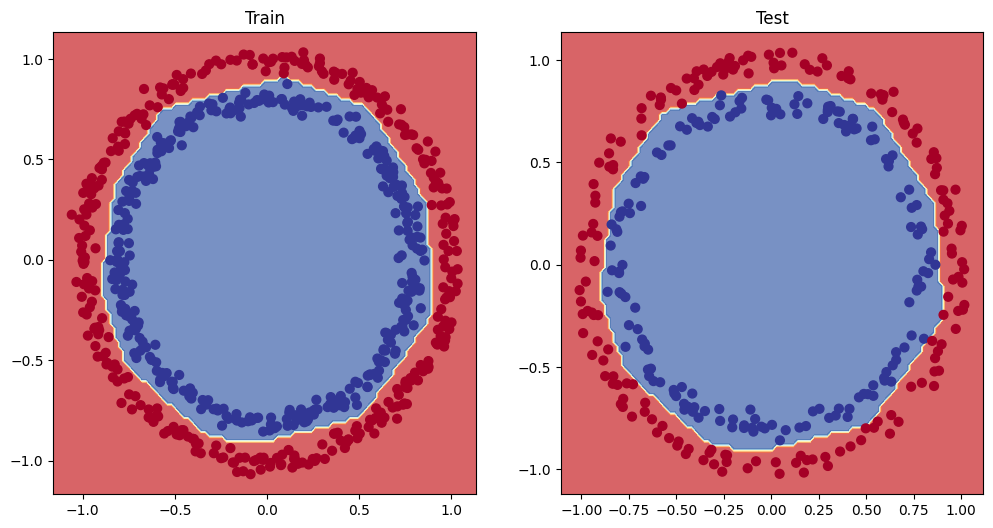

In [146]:
# plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)